# Jonathan Halverson
# Monday, March 27, 2017
# Part 13: Simple predictive models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')
from scipy.stats import binom

In [2]:
iofile = 'data/fightmetric_cards/fightmetric_fights_CLEAN_3-6-2017.csv'
fights = pd.read_csv(iofile, header=0, parse_dates=['Date'])
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"


We remove no contests immediately to avoid inf (infinity) in WinRatio:

In [3]:
fights = fights[fights.Outcome != 'no contest']

In [4]:
# this assume that fights are ordered by date in descending order
# note that no contests are ignored which may not make sense for time_since
num = []
num_wins = []
num_L = []
num_wins_L = []
time_since = []
time_since_L = []
for index, row in fights.iterrows():
     d = row['Date']
     
     winner = row['Winner']
     x = fights[((fights.Winner == winner) | (fights.Loser == winner)) & (fights.Date < d)]
     y = fights[(fights.Winner == winner) & (fights.Date < d)].shape[0]
     # find time since last fight
     if (x.shape[0] > 0):
          weeks = (d - x.Date.sort_values(ascending=False).head(1).iloc[0]) / np.timedelta64(1, 'W')
          time_since.append(weeks)
     else:
          time_since.append(np.nan)
     num.append(x.shape[0])
     num_wins.append(y)
     
     loser = row['Loser']
     x = fights[((fights.Winner == loser) | (fights.Loser == loser)) & (fights.Date < d)]
     y = fights[(fights.Winner == loser) & (fights.Date < d)].shape[0]
     # find time since last fight
     if (x.shape[0] > 0):
          weeks = (d - x.Date.sort_values(ascending=False).head(1).iloc[0]) / np.timedelta64(1, 'W')
          time_since_L.append(weeks)
     else:
          time_since_L.append(np.nan)
     num_L.append(x.shape[0])
     num_wins_L.append(y)
fights['Num'] = num
fights['Num_L'] = num_L
fights['NumWins'] = num_wins
fights['NumWins_L'] = num_wins_L
fights['WinRatio'] = fights.NumWins / fights.Num
fights['WinRatio_L'] = fights.NumWins_L / fights.Num_L
fights['TimeSince'] = time_since
fights['TimeSince_L'] = time_since_L

In [5]:
fights[['Num', 'Num_L', 'NumWins', 'NumWins_L', 'WinRatio', 'WinRatio_L', 'TimeSince', 'TimeSince_L']].describe()

,Num,Num_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L
count,4026.000000,4026.000000,4026.000000,4026.000000,3291.000000,3074.000000,3291.000000,3074.000000
mean,4.426478,4.103577,2.954049,2.608793,0.633479,0.592959,28.824239,31.916907
std,4.612937,4.784857,3.301741,3.299571,0.296247,0.307353,31.779046,37.811264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.857143,2.000000
25%,1.000000,1.000000,0.000000,0.000000,0.500000,0.500000,16.714286,16.857143
50%,3.000000,2.000000,2.000000,1.000000,0.666667,0.625000,22.000000,22.357143
75%,7.000000,6.000000,4.000000,4.000000,0.833333,0.800000,31.000000,34.000000
max,26.000000,26.000000,19.000000,19.000000,1.000000,1.000000,597.142857,581.142857


In [6]:
fights

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Num,Num_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",4,5,3,3,0.750000,0.600000,39.857143,29.000000
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",20,9,16,7,0.800000,0.777778,31.000000,11.000000
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",7,20,6,11,0.857143,0.550000,39.000000,13.000000
3,Glover Teixeira,def.,Jared Cannonier,Light Heavyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",11,3,8,2,0.727273,0.666667,25.000000,10.000000
4,Dustin Poirier,def.,Jim Miller,Lightweight,M-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",16,24,12,17,0.750000,0.708333,21.000000,13.000000
5,Belal Muhammad,def.,Randy Brown,Welterweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",3,4,1,3,0.333333,0.750000,13.000000,9.142857
6,Wilson Reis,def.,Ulka Sasaki,Flyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",7,4,5,2,0.714286,0.500000,28.000000,39.857143
7,Islam Makhachev,def.,Nik Lentz,Lightweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",3,16,2,11,0.666667,0.687500,21.000000,22.000000
8,Rick Glenn,def.,Phillipe Nover,Featherweight,S-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1,6,0,1,0.000000,0.166667,21.000000,20.000000
9,Ryan LaFlare,def.,Roan Carneiro,Welterweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",6,8,5,4,0.833333,0.500000,61.142857,21.000000


In [7]:
x = 'Gray Maynard'
qq = fights[(fights.Winner == x) & (fights.Winner == x)].Date.sort_values(ascending=False).head(1)

In [8]:
qq.item()

1467936000000000000L

In [9]:
qq.iloc[0]

Timestamp('2016-07-08 00:00:00')

In [10]:
fights[fights.WinRatio_L > 1][['Winner', 'WinRatio']]

,Winner,WinRatio


In [11]:
fights.describe()

,Round,Num,Num_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L
count,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,3291.000000,3074.000000,3291.000000,3074.000000
mean,2.247144,4.426478,4.103577,2.954049,2.608793,0.633479,0.592959,28.824239,31.916907
std,1.010392,4.612937,4.784857,3.301741,3.299571,0.296247,0.307353,31.779046,37.811264
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.857143,2.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.500000,0.500000,16.714286,16.857143
50%,3.000000,3.000000,2.000000,2.000000,1.000000,0.666667,0.625000,22.000000,22.357143
75%,3.000000,7.000000,6.000000,4.000000,4.000000,0.833333,0.800000,31.000000,34.000000
max,5.000000,26.000000,26.000000,19.000000,19.000000,1.000000,1.000000,597.142857,581.142857


### Note that win ratio can be NaN

In [12]:
fights.WinRatio.loc[10:20]

10    0.750000
11    0.666667
12    0.833333
13         NaN
14         NaN
15    0.666667
16    0.500000
17    0.714286
18         NaN
19    0.750000
20    1.000000
Name: WinRatio, dtype: float64

In [13]:
iofile = 'data/ufc_name_education.csv'
ufc = pd.read_csv(iofile, header=0)
ufc.head(3)

,Name,Education
0,Jim Alers,1
1,Corey Anderson,1
2,Rich Attonito,1


In [14]:
iofile = 'data/fightmetric_fighters_with_corrections_from_UFC_Wikipedia_CLEAN.csv'
fighters = pd.read_csv(iofile, header=0, parse_dates=['Dob'])
cols = ['Name', 'Height', 'Reach', 'LegReach', 'Stance', 'Dob']
df = fights.merge(fighters[cols], how='left', left_on='Winner', right_on='Name')
df = df.merge(fighters[cols], how='left', left_on='Loser', right_on='Name', suffixes=('', '_L'))
df = df.drop(['Name', 'Name_L'], axis=1)
df = df.merge(ufc, left_on='Winner', right_on='Name', how='left')
df = df.merge(ufc, left_on='Loser', right_on='Name', how='left', suffixes=('', '_L'))
df.Education = df.Education.fillna(0.0)
df.Education_L = df.Education_L.fillna(0.0)
df = df.drop(['Name', 'Name_L'], axis=1)
df.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,LegReach,Stance,Dob,Height_L,Reach_L,LegReach_L,Stance_L,Dob_L,Education,Education_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,41.0,Orthodox,1984-04-24,68.0,69.0,38.0,Southpaw,1981-10-17,0.0,0.0
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,42.0,Southpaw,1975-04-14,73.0,77.0,43.0,Southpaw,1984-01-04,0.0,1.0
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,...,41.0,Orthodox,1979-12-07,72.0,74.0,42.0,Orthodox,1981-01-28,0.0,1.0


In [15]:
iofile = 'data/fightmetric_career_stats.csv'
cstats = pd.read_csv(iofile, header=0)

In [16]:
df = df.merge(cstats, left_on='Winner', right_on='Name', how='left')
df = df.merge(cstats, left_on='Loser', right_on='Name', how='left', suffixes=('', '_L'))
df = df.drop(['Name', 'Name_L'], axis=1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4025
Data columns (total 47 columns):
Winner         4026 non-null object
Outcome        4026 non-null object
Loser          4026 non-null object
WeightClass    4026 non-null object
Method         4026 non-null object
MethodNotes    2154 non-null object
Round          4026 non-null int64
Time           4026 non-null object
Event          4026 non-null object
Date           4026 non-null datetime64[ns]
Location       4026 non-null object
Num            4026 non-null int64
Num_L          4026 non-null int64
NumWins        4026 non-null int64
NumWins_L      4026 non-null int64
WinRatio       3291 non-null float64
WinRatio_L     3074 non-null float64
TimeSince      3291 non-null float64
TimeSince_L    3074 non-null float64
Height         4022 non-null float64
Reach          3762 non-null float64
LegReach       2294 non-null float64
Stance         3905 non-null object
Dob            3970 non-null datetime64[ns]
Height_L   

Filter fights to defeats since January 1, 2005:

In [18]:
fs = df[(df.Date > pd.to_datetime('2005-01-01')) & (df.Outcome == 'def.')].copy()
fs.shape[0]

3561

In [19]:
fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3580
Data columns (total 47 columns):
Winner         3561 non-null object
Outcome        3561 non-null object
Loser          3561 non-null object
WeightClass    3561 non-null object
Method         3561 non-null object
MethodNotes    1860 non-null object
Round          3561 non-null int64
Time           3561 non-null object
Event          3561 non-null object
Date           3561 non-null datetime64[ns]
Location       3561 non-null object
Num            3561 non-null int64
Num_L          3561 non-null int64
NumWins        3561 non-null int64
NumWins_L      3561 non-null int64
WinRatio       2992 non-null float64
WinRatio_L     2829 non-null float64
TimeSince      2992 non-null float64
TimeSince_L    2829 non-null float64
Height         3561 non-null float64
Reach          3538 non-null float64
LegReach       2242 non-null float64
Stance         3454 non-null object
Dob            3559 non-null datetime64[ns]
Height_L   

### Younger wins

In [20]:
yw = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & (fs.Dob != fs.Dob_L)]
wins = yw[yw.Dob > yw.Dob_L].shape[0]
total = yw.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1964, 3529, 0.5565315953527912, 32, 1.9906913544237038e-11)

### Longer reach wins

In [21]:
lr = fs[pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L) & (fs.Reach != fs.Reach_L)]
wins = lr[lr.Reach > lr.Reach_L].shape[0]
total = lr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1499, 2863, 0.5235766678309466, 698, 0.012254511782245889)

What if we don't exclude nulls?

In [22]:
lr = fs[fs.Reach != fs.Reach_L]
wins = lr[lr.Reach > lr.Reach_L].shape[0]
total = lr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total

(1499, 3138, 0.47769279796048436, 423)

In [23]:
71.0 > np.nan

False

In [24]:
71.0 == np.nan

False

In [25]:
lr[['Reach', 'Reach_L']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3138 entries, 0 to 3580
Data columns (total 2 columns):
Reach      3115 non-null float64
Reach_L    2877 non-null float64
dtypes: float64(2)
memory usage: 73.5 KB


We see that nulls in Reach_L lead to Falses which increased the total which gave a win ratio less than 1/2.

### Taller wins

In [26]:
ht = fs[pd.notnull(fs.Height) & pd.notnull(fs.Height_L) & (fs.Height != fs.Height_L)]
wins = ht[ht.Height > ht.Height_L].shape[0]
total = ht.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1486, 2903, 0.511884257664485, 658, 0.20691383522689766)

### Stance

In [27]:
st = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & (((fs.Stance == 'Orthodox') & (fs.Stance_L == 'Southpaw')) | ((fs.Stance == 'Southpaw') & (fs.Stance_L == 'Orthodox')))]
wins = st[st.Stance == 'Southpaw'].shape[0]
total = st.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(561, 1010, 0.5554455445544555, 2551, 0.00047237811629372023)

### Education

In [28]:
ed = fs[pd.notnull(fs.Education) & pd.notnull(fs.Education_L) & (fs.Education != fs.Education_L)]
wins = ed[ed.Education == 1].shape[0]
total = ed.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(594, 1051, 0.5651760228353948, 2510, 2.6619836969235326e-05)

### Leg reach

In [29]:
lg = fs[pd.notnull(fs.LegReach) & pd.notnull(fs.LegReach_L) & (fs.LegReach != fs.LegReach_L)]
wins = lg[lg.LegReach > lg.LegReach_L].shape[0]
total = lg.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(487, 993, 0.4904330312185297, 2568, 0.56787738449981351)

### Predict winner has more UFC fights

In [30]:
nf = fs[pd.notnull(fs.Num) & pd.notnull(fs.Num_L) & (fs.Num != fs.Num_L)]
wins = nf[nf.Num > nf.Num_L].shape[0]
total = nf.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1606, 2886, 0.5564795564795565, 675, 1.3957729165251447e-09)

### Predict winner has higher win ratio (for 5 fights or more)

In [31]:
wr = fs[pd.notnull(fs.WinRatio) & pd.notnull(fs.WinRatio_L) & (fs.WinRatio != fs.WinRatio_L) & (fs.Num > 4) & (fs.Num_L > 4)]
wins = wr[wr.WinRatio > wr.WinRatio_L].shape[0]
total = wr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(439, 737, 0.5956580732700135, 2824, 2.3149181853620525e-07)

In [32]:
# How does the result change if we replace NaN with 0.5 and don't require a certain number of fights?
# Ans: (1571, 2728, 0.5758797653958945, 833, 2.331962646952389e-15)
#fs.WinRatio = fs.WinRatio.fillna(0.5)
#fs.WinRatio_L = fs.WinRatio_L.fillna(0.5)

### Fighter who fought more recently wins

In [33]:
vd = fs[pd.notnull(fs.TimeSince) & pd.notnull(fs.TimeSince_L) & (fs.TimeSince != fs.TimeSince_L)]

wins = vd[vd.TimeSince < vd.TimeSince_L].shape[0]
total = vd.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1220, 2353, 0.5184870378240544, 1208, 0.076220775718697079)

### Higher win ratio and younger

In [34]:
vd = fs[pd.notnull(fs.WinRatio) & pd.notnull(fs.WinRatio_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & (fs.WinRatio != fs.WinRatio_L) & (fs.Dob != fs.Dob_L) & (fs.Num > 4) & (fs.Num_L > 4)]
msk1 = (vd.WinRatio > vd.WinRatio_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.WinRatio < vd.WinRatio_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.WinRatio > sp.WinRatio_L].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(256, 407, 0.628992628992629, 3154, 2.1864763337164381e-07)

### Reach advantage of 4 inches or more

In [35]:
vd = fs[pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = np.abs(vd.Reach - vd.Reach_L) >= 4

sp = vd[msk1]
wins = sp[(sp.Reach > sp.Reach_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(523, 942, 0.5552016985138004, 2619, 0.00078230416432338058)

In [36]:
sp[['Winner', 'Reach', 'Loser', 'Reach_L']].head(10)

,Winner,Reach,Loser,Reach_L
5,Belal Muhammad,72.0,Randy Brown,78.0
6,Wilson Reis,65.0,Ulka Sasaki,71.0
10,Chan Sung Jung,72.0,Dennis Bermudez,66.0
12,James Vick,76.0,Abel Trujillo,70.0
13,Volkan Oezdemir,75.0,Ovince Saint Preux,80.0
16,Curtis Blaydes,80.0,Adam Milstead,76.0
17,Chas Skelly,72.0,Chris Gruetzemacher,68.0
18,Ricardo Ramos,72.0,Michinori Tanaka,67.0
19,Tecia Torres,60.0,Bec Rawlings,64.0
20,Niko Price,76.0,Alex Morono,72.0


### 4 years or more younger

In [37]:
vd = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L)]
msk1 = ((vd.Dob - vd.Dob_L) / np.timedelta64(1, 'Y'))**2 >= 16

sp = vd[msk1]
wins = sp[(sp.Dob > sp.Dob_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(893, 1511, 0.5909993381866314, 2050, 1.5717573327498843e-12)

In [38]:
sp[['Winner', 'Dob', 'Loser', 'Dob_L']].head(20)

,Winner,Dob,Loser,Dob_L
1,Anderson Silva,1975-04-14,Derek Brunson,1984-01-04
3,Glover Teixeira,1979-10-28,Jared Cannonier,1984-03-16
4,Dustin Poirier,1989-01-19,Jim Miller,1983-08-30
6,Wilson Reis,1985-01-06,Ulka Sasaki,1989-10-07
7,Islam Makhachev,1991-10-27,Nik Lentz,1984-08-13
8,Rick Glenn,1989-04-12,Phillipe Nover,1984-02-03
9,Ryan LaFlare,1983-10-01,Roan Carneiro,1978-06-02
11,Felice Herrig,1984-09-18,Alexa Grasso,1993-08-09
13,Volkan Oezdemir,1989-09-19,Ovince Saint Preux,1983-04-08
14,Marcel Fortuna,1985-10-22,Anthony Hamilton,1980-04-14


### Younger and greater reach

In [39]:
vd = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = (vd.Reach > vd.Reach_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.Reach < vd.Reach_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[(sp.Dob > sp.Dob_L) & (sp.Reach > sp.Reach_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(919, 1607, 0.5718730553827007, 1954, 9.082436176617217e-09)

### Southpaw and younger

In [40]:
vd = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L)]
msk1 = (vd.Stance == 'Southpaw') & (vd.Stance_L == 'Orthodox') & (vd.Dob > vd.Dob_L)
msk2 = (vd.Stance == 'Orthodox') & (vd.Stance_L == 'Southpaw') & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.Stance == 'Southpaw'].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(284, 460, 0.6173913043478261, 3101, 5.4168911673341359e-07)

### South, younger and greater reach

In [41]:
vd = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = (vd.Stance == 'Southpaw') & (vd.Stance_L == 'Orthodox') & (vd.Reach > vd.Reach_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.Stance == 'Orthodox') & (vd.Stance_L == 'Southpaw') & (vd.Reach < vd.Reach_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.Stance == 'Southpaw'].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(132, 213, 0.6197183098591549, 3348, 0.00058036677808886463)

In [42]:
sp[['Winner', 'Dob', 'Reach', 'Stance', 'Loser', 'Dob_L', 'Reach_L', 'Stance_L']].head()

,Winner,Dob,Reach,Stance,Loser,Dob_L,Reach_L,Stance_L
26,Sam Alvey,1986-05-06,75.0,Southpaw,Nate Marquardt,1979-04-20,74.0,Orthodox
33,Jason Gonzalez,1990-02-28,74.0,Southpaw,JC Cottrell,1989-11-04,71.0,Orthodox
67,Sultan Aliev,1984-09-17,74.0,Orthodox,Bojan Velickovic,1988-12-18,76.0,Southpaw
91,Juliana Lima,1982-03-15,65.0,Orthodox,JJ Aldrich,1992-09-29,67.0,Southpaw
92,Demetrious Johnson,1986-08-13,64.0,Orthodox,Tim Elliott,1986-12-24,65.0,Southpaw


### Overall win ratio

In [43]:
fs_fighters = fs.Winner.append(fs.Loser).value_counts().to_frame()
wins = fs.Winner.value_counts().to_frame()
loses = fs.Loser.value_counts().to_frame()
fs_fighters = fs_fighters.merge(wins, left_index=True, right_index=True, how='left')
fs_fighters = fs_fighters.merge(loses, left_index=True, right_index=True, how='left')
fs_fighters = fs_fighters.fillna(0.0)
fs_fighters.columns = ['Total', 'Wins', 'Losses']
fs_fighters['WinRatio'] = fs_fighters.Wins / (fs_fighters.Wins + fs_fighters.Losses)

In [44]:
ws = fs.merge(fs_fighters[['Total', 'WinRatio']], left_on='Winner', right_index=True, how='left')
ws = ws.merge(fs_fighters[['Total', 'WinRatio']], left_on='Loser', right_index=True, how='left', suffixes=('', '_L'))
ws.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,sapm_L,str_def_L,td_avg_L,td_acc_L,td_def_L,sub_avg_L,Total,WinRatio_y,Total_L,WinRatio
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,2.65,0.59,0.27,0.18,0.78,0.0,5,0.800000,6,0.50000
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,2.62,0.50,3.13,0.32,1.00,0.7,21,0.809524,10,0.70000
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,...,2.80,0.56,1.64,0.35,0.58,0.9,8,0.875000,21,0.52381


In [45]:
ws = ws[pd.notnull(ws.WinRatio) & pd.notnull(ws.WinRatio_L) & (ws.Total > 5) & (ws.Total_L > 5)]
wins = ws[ws.WinRatio > ws.WinRatio_L].shape[0]
total = ws.shape[0]
wins, total, wins / float(total), ws.shape[0] - total

(147, 1577, 0.0932149651236525, 0)

# Part II: Cleaning, imputing and standardizing

In [46]:
fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3580
Data columns (total 47 columns):
Winner         3561 non-null object
Outcome        3561 non-null object
Loser          3561 non-null object
WeightClass    3561 non-null object
Method         3561 non-null object
MethodNotes    1860 non-null object
Round          3561 non-null int64
Time           3561 non-null object
Event          3561 non-null object
Date           3561 non-null datetime64[ns]
Location       3561 non-null object
Num            3561 non-null int64
Num_L          3561 non-null int64
NumWins        3561 non-null int64
NumWins_L      3561 non-null int64
WinRatio       2992 non-null float64
WinRatio_L     2829 non-null float64
TimeSince      2992 non-null float64
TimeSince_L    2829 non-null float64
Height         3561 non-null float64
Reach          3538 non-null float64
LegReach       2242 non-null float64
Stance         3454 non-null object
Dob            3559 non-null datetime64[ns]
Height_L   

In [69]:
fs['Age'] = (fs.Date - fs.Dob) / np.timedelta64(1, 'Y')
fs['Age_L'] = (fs.Date - fs.Dob_L) / np.timedelta64(1, 'Y')

In [70]:
fs.Stance.value_counts()

Orthodox       2620
Southpaw        751
Switch           70
Open Stance      13
Name: Stance, dtype: int64

In [71]:
fs.Stance_L.value_counts()

Orthodox       2704
Southpaw        636
Switch           79
Open Stance       9
Sideways          1
Name: Stance_L, dtype: int64

In [72]:
gs = fs[fs.Stance.isin(['Southpaw', 'Orthodox', 'Switch']) & fs.Stance_L.isin(['Southpaw', 'Orthodox', 'Switch'])].copy()

Replace NaN's in win ratios:

In [73]:
gs.WinRatio = gs.WinRatio.fillna(0.5)
gs.WinRatio_L = gs.WinRatio_L.fillna(0.5)

In [74]:
gs.Stance = gs.Stance.replace({'Switch':'Orthodox'}).replace({'Southpaw':1, 'Orthodox':0})
gs.Stance_L = gs.Stance_L.replace({'Switch':'Orthodox'}).replace({'Switch':2, 'Southpaw':1, 'Orthodox':0})

In [75]:
#gs.LegReach = gs.LegReach.apply()

In [76]:
cols = ['Reach', 'Height', 'LegReach', 'Stance', 'Num', 'WinRatio', 'Education', 'Age', 'Reach_L', 'Height_L', 'LegReach_L', 'Stance_L', 'Num_L', 'WinRatio_L', 'Education_L', 'Age_L']
cols = ['Reach', 'Height', 'Stance', 'Num', 'WinRatio', 'Education', 'Age', 'Reach_L', 'Height_L', 'Stance_L', 'Num_L', 'WinRatio_L', 'Education_L', 'Age_L']
gs[cols].head()

,Reach,Height,Stance,Num,WinRatio,Education,Age,Reach_L,Height_L,Stance_L,Num_L,WinRatio_L,Education_L,Age_L
0,71.0,69.0,0,4,0.750000,0.0,32.802864,69.0,68.0,1,5,0.600000,0.0,35.321738
1,77.0,74.0,1,20,0.800000,0.0,41.832481,77.0,73.0,1,9,0.777778,1.0,33.106772
2,72.0,73.0,0,7,0.857143,0.0,37.183515,74.0,72.0,0,20,0.550000,1.0,36.039070
3,76.0,74.0,0,11,0.727273,0.0,37.293031,77.0,71.0,0,3,0.666667,0.0,32.909642
4,72.0,69.0,1,16,0.750000,0.0,28.063547,71.0,68.0,1,24,0.708333,0.0,33.454486


In [77]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3329 entries, 0 to 3580
Data columns (total 49 columns):
Winner         3329 non-null object
Outcome        3329 non-null object
Loser          3329 non-null object
WeightClass    3329 non-null object
Method         3329 non-null object
MethodNotes    1747 non-null object
Round          3329 non-null int64
Time           3329 non-null object
Event          3329 non-null object
Date           3329 non-null datetime64[ns]
Location       3329 non-null object
Num            3329 non-null int64
Num_L          3329 non-null int64
NumWins        3329 non-null int64
NumWins_L      3329 non-null int64
WinRatio       3329 non-null float64
WinRatio_L     3329 non-null float64
TimeSince      2830 non-null float64
TimeSince_L    2676 non-null float64
Height         3329 non-null float64
Reach          3308 non-null float64
LegReach       2081 non-null float64
Stance         3329 non-null int64
Dob            3327 non-null datetime64[ns]
Height_L    

In [78]:
#gs = gs[cols]
gs['AgeDiff'] = gs.Age - gs.Age_L
gs['ReachDiff'] = gs.Reach - gs.Reach_L
gs['StanceDiff'] = gs.Stance - gs.Stance_L
gs['EducationDiff'] = gs.Education - gs.Education_L
gs['WinRatioDiff'] = gs.WinRatio - gs.WinRatio_L
gs['NumFightsDiff'] = gs.Num - gs.Num_L
gs['TimeSinceDiff'] = gs.TimeSince - gs.TimeSince_L
gs['SApMDiff'] = gs.sapm - gs.sapm_L
gs['SLpMDiff'] = gs.slpm - gs.slpm_L
gs['TDavgDiff'] = gs.td_avg - gs.td_avg_L
gs['TDdefDiff'] = gs.td_def - gs.td_def_L
gs['SubavgDiff'] = gs.sub_avg - gs.sub_avg_L
gs = gs[['AgeDiff', 'ReachDiff', 'StanceDiff', 'EducationDiff', 'TimeSinceDiff', 'WinRatioDiff', 'NumFightsDiff', 'SApMDiff', 'SLpMDiff', 'TDavgDiff', 'TDdefDiff', 'SubavgDiff']]
gs.TimeSinceDiff = gs.TimeSinceDiff.fillna(0.0)
gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3329 entries, 0 to 3580
Data columns (total 12 columns):
AgeDiff          3300 non-null float64
ReachDiff        3075 non-null float64
StanceDiff       3329 non-null int64
EducationDiff    3329 non-null float64
TimeSinceDiff    3329 non-null float64
WinRatioDiff     3329 non-null float64
NumFightsDiff    3329 non-null int64
SApMDiff         3329 non-null float64
SLpMDiff         3329 non-null float64
TDavgDiff        3329 non-null float64
TDdefDiff        3329 non-null float64
SubavgDiff       3329 non-null float64
dtypes: float64(10), int64(2)
memory usage: 338.1 KB


In [94]:
gs.head()

,AgeDiff,ReachDiff,StanceDiff,EducationDiff,TimeSinceDiff,WinRatioDiff,NumFightsDiff,SApMDiff,SLpMDiff,TDavgDiff,TDdefDiff,SubavgDiff
0,-2.518874,2.0,-1,0.0,10.857143,0.150000,-1,-0.37,0.12,-0.27,0.08,0.2
1,8.725710,0.0,0,-1.0,20.000000,0.022222,11,-0.75,-0.03,-2.58,-0.31,0.2
2,1.144445,-2.0,0,-1.0,26.000000,0.307143,-13,-0.80,-0.51,1.86,0.00,1.0
3,4.383389,-1.0,0,0.0,15.000000,0.060606,8,0.70,0.75,2.63,0.28,0.8
4,-5.390939,1.0,0,0.0,8.000000,0.041667,-8,0.74,2.22,0.09,0.20,-0.8


In [95]:
gs.describe()

,AgeDiff,ReachDiff,StanceDiff,EducationDiff,TimeSinceDiff,WinRatioDiff,NumFightsDiff,SApMDiff,SLpMDiff,TDavgDiff,TDdefDiff,SubavgDiff
count,3300.000000,3075.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000
mean,-0.721093,0.259512,0.035446,0.038450,-1.975797,0.040126,0.291078,-0.371184,0.379411,0.278399,0.074992,0.047101
std,5.002731,3.366972,0.557353,0.547909,39.925693,0.311320,5.301628,1.535469,1.376467,1.864379,0.303433,1.221592
min,-16.931217,-12.000000,-1.000000,-1.000000,-554.142857,-1.000000,-21.000000,-20.230000,-4.790000,-11.770000,-1.000000,-11.900000
25%,-4.019247,-2.000000,0.000000,0.000000,-5.428571,-0.107692,-2.000000,-1.090000,-0.470000,-0.840000,-0.120000,-0.500000
50%,-0.706380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,0.380000,0.260000,0.070000,0.000000
75%,2.555836,2.000000,0.000000,0.000000,4.000000,0.214286,3.000000,0.540000,1.270000,1.370000,0.260000,0.600000
max,15.904502,13.000000,1.000000,1.000000,578.142857,1.000000,24.000000,8.100000,7.240000,13.430000,1.000000,12.100000


In [81]:
shuffled = []
from random import random as rng
for index, row in gs.iterrows():
     if (rng() < 0.5):
          #shuffled.append(([1] + list(row[7:].values) + list(row[:7].values)))
          shuffled.append(([1] + list(-1 * row.values)))
     else:
          shuffled.append(([0] + list(row.values)))

In [82]:
data = pd.DataFrame(shuffled)
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,3329.000000,3300.000000,3075.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000
mean,0.497747,-0.069017,0.032195,0.009012,-0.000601,0.059735,0.007888,-0.051367,-0.015041,0.019591,-0.048480,-0.001475,0.004806
std,0.500070,5.053978,3.376808,0.558406,0.549256,39.974521,0.313797,5.309366,1.579638,1.427681,1.884433,0.312562,1.222491
min,0.000000,-16.536958,-12.000000,-1.000000,-1.000000,-578.142857,-1.000000,-24.000000,-20.230000,-6.370000,-11.110000,-1.000000,-12.100000
25%,0.000000,-3.353936,-2.000000,0.000000,0.000000,-5.000000,-0.166667,-3.000000,-0.840000,-0.900000,-1.170000,-0.190000,-0.500000
50%,0.000000,-0.142371,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.010000,0.020000,-0.040000,0.000000,0.000000
75%,1.000000,3.234837,2.000000,-0.000000,0.000000,4.285714,0.166667,2.000000,0.810000,0.960000,1.120000,0.200000,0.500000
max,1.000000,16.931217,13.000000,1.000000,1.000000,471.142857,1.000000,21.000000,9.620000,7.240000,13.430000,1.000000,11.800000


In [112]:
sorted(data.corr().applymap(lambda x: abs(round(x, 2))).values.flatten().tolist(), reverse=True)[:15]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.29, 0.29]

In [83]:
cols = [0, 1, 3, 7, 8, 10, 14]
cols = [0, 7, 14]
#cols = [0, 3, 10]
cols = range(data.shape[1])
data = data.loc[:,cols].dropna()
data = data.sample(data.shape[0], replace=False, axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3070 entries, 2967 to 688
Data columns (total 13 columns):
0     3070 non-null int64
1     3070 non-null float64
2     3070 non-null float64
3     3070 non-null float64
4     3070 non-null float64
5     3070 non-null float64
6     3070 non-null float64
7     3070 non-null float64
8     3070 non-null float64
9     3070 non-null float64
10    3070 non-null float64
11    3070 non-null float64
12    3070 non-null float64
dtypes: float64(12), int64(1)
memory usage: 335.8 KB


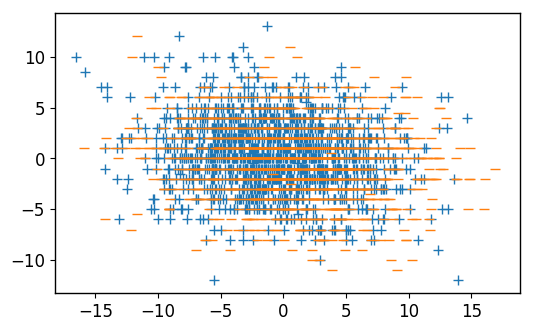

In [84]:
plt.scatter(data[data.loc[:,0]==0].iloc[:,1], data[data.loc[:,0]==0].iloc[:,2], marker='+')
plt.scatter(data[data.loc[:,0]==1].iloc[:,1], data[data.loc[:,0]==1].iloc[:,2], marker='_')

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [86]:
from sklearn.tree import DecisionTreeClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(max_depth=range(1, 10), criterion=['gini', 'entropy'], splitter=['best', 'random'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = DecisionTreeClassifier(random_state=0)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

0 0.64727780363 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 4} 0.625407166124
1 0.623545835272 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 5} 0.646036916395
2 0.631456491391 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4} 0.617806731813
3 0.637040483946 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 4} 0.606948968512
4 0.626803164262 {'splitter': 'random', 'criterion': 'entropy', 'max_depth': 6} 0.598262757872
5 0.637971149372 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 5} 0.601520086862
6 0.612843182876 {'splitter': 'random', 'criterion': 'gini', 'max_depth': 5} 0.608034744843
7 0.617961842718 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 3} 0.631921824104
8 0.617496510005 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 3} 0.646036916395
9 0.62959516054 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 6} 0.624321389794


In [87]:
np.array(test_accuracies).mean()

0.62062975027144396

Write out the optimal tree to graph file:

In [ ]:
# http://webgraphviz.com (paste contents of file here)
#from sklearn import tree
#fn = ['stance1', 'age1', 'stance2', 'age2']
#cn = ['fighter1 wins', 'fighter2 wins']
#clf.set_params(**grid.best_params_).fit(X_train, y_train)
#tree.export_graphviz(clf, out_file='tree.dot', feature_names=fn, class_names=cn)

In [ ]:
# uncomment below to see log
#grid.cv_results_

### Evaluation of the classifer

In [ ]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
confmat

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
     for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [ ]:
metrics.recall_score(y_test, y_test_pred)

In [ ]:
metrics.precision_score(y_test, y_test_pred)

### ROC curve

In [ ]:
# store the predicted probabilities for class 1 
y_pred_prob = grid.predict_proba(X_test)[:,1]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')

In [ ]:
metrics.roc_auc_score(y_test, y_pred_prob)

# Other models

### Random Forest

from sklearn.ensemble import RandomForestClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(criterion=['gini', 'entropy'], bootstrap=[True, False])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = RandomForestClassifier(n_estimators=100)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegression

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(C=np.logspace(-4, 1, base=10, num=25), penalty=['l1', 'l2'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = LogisticRegression()
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

0 0.662633783155 {'penalty': 'l2', 'C': 0.0017782794100389228} 0.651465798046
1 0.657980456026 {'penalty': 'l2', 'C': 0.012115276586285889} 0.671009771987
2 0.661703117729 {'penalty': 'l2', 'C': 0.051089697745069294} 0.663409337676
3 0.656584457887 {'penalty': 'l2', 'C': 0.00016155980984398745} 0.646036916395
4 0.680781758958 {'penalty': 'l1', 'C': 0.082540418526801898} 0.638436482085
5 0.670544439274 {'penalty': 'l2', 'C': 0.012115276586285889} 0.646036916395
6 0.663099115868 {'penalty': 'l2', 'C': 0.0046415888336127824} 0.661237785016
7 0.656119125174 {'penalty': 'l2', 'C': 0.012115276586285889} 0.674267100977
8 0.660772452303 {'penalty': 'l2', 'C': 0.0017782794100389228} 0.669923995657
9 0.660307119591 {'penalty': 'l1', 'C': 0.082540418526801898} 0.666666666667


In [93]:
np.array(test_accuracies).mean()

0.65884907709011942

### AdaBoost

from sklearn.ensemble import AdaBoostClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(learning_rate=np.logspace(-4, 0, base=10, num=5),
                  n_estimators=[25, 50, 100],
                  base_estimator__max_depth=[1, 2, 3])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     tree = DecisionTreeClassifier(criterion='entropy')
     clf = AdaBoostClassifier(tree)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Support Vector Classifier

from sklearn.svm import SVC

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = [dict(kernel=['linear'],
                   C=np.logspace(-3, 3, base=10, num=15),
                   shrinking=[True, False])]
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = SVC(probability=True)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Bagged Logistic Regression

In [ ]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(n_estimators=[25, 50],
                  bootstrap_features=[True, False],
                  base_estimator__C=np.logspace(-3, 3, base=10, num=15),
                  base_estimator__penalty=['l1', 'l2'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     lr = LogisticRegression()
     clf = BaggingClassifier(base_estimator=lr)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()